# Import Libraries

In [1]:
import argparse
import math
import os
import os.path as ops
import time

import cv2
import glog as log
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# ignore warning for tf 2.0
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(tf.__version__)

1.13.0-rc2


# Setting Data Set and Weights Path

In [4]:
dataset_dir = 'data/training_data_bdd100k_highway_lane_t5/'
weights_path = 'model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000'

# Setting parameters

In [5]:
__C = edict()

cfg = __C

__C.TRAIN = edict()
__C.TRAIN.EPOCHS = 10000
__C.TRAIN.NOOFBATCHES = 10
__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.LEARNING_RATE = 0.0005
__C.TRAIN.GPU_MEMORY_FRACTION = 0.85
__C.TRAIN.TF_ALLOW_GROWTH = True
__C.TRAIN.BATCH_SIZE = 8
__C.TRAIN.IMG_HEIGHT = 256
__C.TRAIN.IMG_WIDTH = 512

# Reading Data Set

In [6]:
class DataSet(object):
    def __init__(self, dataset_info_file):
        self._gt_img_list, self._gt_label_binary_list = self._init_dataset(dataset_info_file)
        self._random_dataset()
        self._next_batch_loop_count = 0

    def _init_dataset(self, dataset_info_file):
        gt_img_list = []
        gt_label_binary_list = []

        assert ops.exists(dataset_info_file), '{:s}　does not exist'.format(dataset_info_file)

        with open(dataset_info_file, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                gt_img_list.append(info_tmp[0])
                gt_label_binary_list.append(info_tmp[1])

        return gt_img_list, gt_label_binary_list

    def _random_dataset(self):
        assert len(self._gt_img_list) == len(self._gt_label_binary_list)

        random_idx = np.random.permutation(len(self._gt_img_list))
        new_gt_img_list = []
        new_gt_label_binary_list = []

        for index in random_idx:
            new_gt_img_list.append(self._gt_img_list[index])
            new_gt_label_binary_list.append(self._gt_label_binary_list[index])

        self._gt_img_list = new_gt_img_list
        self._gt_label_binary_list = new_gt_label_binary_list

    def next_batch(self, batch_size):
        assert len(self._gt_label_binary_list) == len(self._gt_img_list)

        idx_start = batch_size * self._next_batch_loop_count
        idx_end = batch_size * self._next_batch_loop_count + batch_size

        if idx_start == 0 and idx_end > len(self._gt_label_binary_list):
            raise ValueError('Batch size cannot be larger than the total number of samples', 
                             idx_end, len(self._gt_label_binary_list))

        if idx_end > len(self._gt_label_binary_list):
            self._random_dataset()
            self._next_batch_loop_count = 0
            return self.next_batch(batch_size)
        else:
            gt_img_list = self._gt_img_list[idx_start:idx_end]
            gt_label_binary_list = self._gt_label_binary_list[idx_start:idx_end]

            gt_imgs = []
            gt_labels_binary = []

            for gt_img_path in gt_img_list:
                gt_imgs.append(cv2.imread(gt_img_path, cv2.IMREAD_COLOR))

            for gt_label_path in gt_label_binary_list:
                label_img = cv2.imread(gt_label_path, cv2.IMREAD_COLOR)
                label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
                idx = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
                label_binary[idx] = 1
                gt_labels_binary.append(label_binary)

            self._next_batch_loop_count += 1

        return gt_imgs, gt_labels_binary

In [7]:
# train dataset
train_dataset_file = ops.join(dataset_dir, 'train.txt')
assert ops.exists(train_dataset_file)
train_dataset = DataSet(train_dataset_file)

# CNN Base Function
## cnn_basenet.py

In [8]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [in_channel / split, out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [in_channel / split, out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format) if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, \
                   padding='VALID', data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(value=inputdata, ksize=kernel, strides=strides, \
                              padding=padding, data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)
        return ret

# Defining model using conv2d, Relu and Maxpooling

## fcn_decoder.py

In [9]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [10]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [11]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def _build_model(self, input_tensor, name):
        with tf.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')
            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def compute_loss(self, input_tensor, binary_label, name):
        with tf.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')

            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_label_plain = tf.reshape(binary_label,
                                            shape=[binary_label.get_shape().as_list()[0] *
                                                   binary_label.get_shape().as_list()[1] *
                                                   binary_label.get_shape().as_list()[2]])
            # Add class weights
            unique_labels, unique_id, counts = tf.unique_with_counts(binary_label_plain)
            counts = tf.cast(counts, tf.float32)
            inverse_weights = tf.divide(1.0,
                                        tf.log(tf.add(tf.divide(tf.constant(1.0), counts),
                                                      tf.constant(1.02))))
            inverse_weights = tf.gather(inverse_weights, binary_label)
            binary_segmenatation_loss = tf.losses.sparse_softmax_cross_entropy(labels=binary_label, \
                                                                               logits=decode_logits, \
                                                                               weights=inverse_weights)
            binary_segmenatation_loss = tf.reduce_mean(binary_segmenatation_loss)

            ret = {'loss': binary_segmenatation_loss, 'binary_seg_logits': decode_logits}

            return ret

# Define cost, optimizer and accuracy

In [12]:
CFG = cfg

In [13]:
with tf.device('/gpu:0'):
    input_tensor = tf.placeholder(dtype=tf.float32,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 3],
                                  name='input_tensor')
    binary_label = tf.placeholder(dtype=tf.int64,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 1],
                                         name='binary_label')

    # Create the model
    phase = tf.placeholder(dtype=tf.string, shape=None, name='net_phase')
    net = LaneNet(phase=phase)

    # Define loss
    compute_ret = net.compute_loss(input_tensor=input_tensor, binary_label=binary_label, name='lanenet_model')
    loss = compute_ret['loss']

    # Evaluate model
    out_logits = compute_ret['binary_seg_logits']
    out_logits = tf.nn.softmax(logits=out_logits)
    out_logits_out = tf.argmax(out_logits, axis=-1)
    out = tf.argmax(out_logits, axis=-1)
    out = tf.expand_dims(out, axis=-1)

    idx = tf.where(tf.equal(binary_label, 1))
    pix_cls_ret = tf.gather_nd(out, idx)
    accuracy = tf.count_nonzero(pix_cls_ret)
    accuracy = tf.divide(accuracy, tf.cast(tf.shape(pix_cls_ret)[0], tf.int64))

    # Define optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(CFG.TRAIN.LEARNING_RATE, global_step,
                                               100000, 0.1, staircase=True)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, \
                                               momentum=CFG.TRAIN.MOMENTUM).minimize(loss=loss,
                                                                                     var_list=tf.trainable_variables(),
                                                                                     global_step=global_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Set a session

In [14]:
# Set sess configuration
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=sess_config)

In [15]:
# Set tf saver
model_save_dir = 'model/tusimple_lanenet'
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)

train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = 'tusimple_lanenet_{:s}.ckpt'.format(str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

saver = tf.train.Saver()

tf.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                     name='{:s}/lanenet_model.pb'.format(model_save_dir))

'model/tusimple_lanenet/lanenet_model.pb'

In [16]:
# Set tf summary
tboard_save_path = 'tboard/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(tboard_save_path):
    os.makedirs(tboard_save_path)

train_accuracy_scalar = tf.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_scalar = tf.summary.scalar(name='train_loss', tensor=loss)
learning_rate_scalar = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
merged_summary_op = tf.summary.merge([train_accuracy_scalar, train_loss_scalar, learning_rate_scalar])

summary_writer = tf.summary.FileWriter(tboard_save_path)
summary_writer.add_graph(sess.graph)

In [17]:
# Set output image folder
image_save_path = 'data_ret/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(image_save_path):
    os.makedirs(image_save_path)

# Running the session

In [18]:
VGG_MEAN = [103.939, 116.779, 123.68]

history = []
train_cost_time_mean = []

In [19]:
def resize_training_data(gt_imgs, binary_gt_labels):
    gt_imgs = [cv2.resize(tmp,
                          dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                          dst=tmp,
                          interpolation=cv2.INTER_LINEAR)
               for tmp in gt_imgs]
    gt_imgs = [tmp - VGG_MEAN for tmp in gt_imgs]

    binary_gt_labels = [cv2.resize(tmp,
                                   dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                                   dst=tmp,
                                   interpolation=cv2.INTER_NEAREST)
                        for tmp in binary_gt_labels]
    binary_gt_labels = [np.expand_dims(tmp, axis=-1) for tmp in binary_gt_labels]
    
    return gt_imgs, binary_gt_labels

In [20]:
with sess.as_default():
    # sess init or restore
    if weights_path is None:
        log.info('Training from scratch')
        init = tf.global_variables_initializer()
        sess.run(init)

        # read vgg model
        pretrained_weights = np.load('./data/vgg16.npy', encoding='latin1').item()
        for vv in tf.trainable_variables():
            weights_key = vv.name.split('/')[-3]
            try:
                weights = pretrained_weights[weights_key][0]
                _op = tf.assign(vv, weights)
                sess.run(_op)
            except Exception as e:
                continue
    else:
        log.info('Restore model from last model checkpoint {:s}'.format(weights_path))
        # restore weights
        saver.restore(sess=sess, save_path=weights_path)

    # epoch loop
    for epoch in range(CFG.TRAIN.EPOCHS):

        # Use training data for optimization
        for _ in range(CFG.TRAIN.NOOFBATCHES):
            with tf.device('/cpu:0'):
                gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
                gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

            sess.run(optimizer, feed_dict={input_tensor:gt_imgs, 
                                           binary_label:binary_gt_labels, 
                                           phase:'train'})

        # Validate after every epoch
        t_start = time.time()
        with tf.device('/cpu:0'):
            gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        train_loss, train_accuracy, train_img, train_summary = \
            sess.run([loss, accuracy, out_logits_out, merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'train'})

        # time
        cost_time = time.time() - t_start
        train_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=train_summary, global_step=epoch)

        # history
        if epoch*CFG.TRAIN.NOOFBATCHES > 10:
            history.append([train_loss, train_accuracy])

        # progress
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            print('Epoch: {:6d} loss= {:6f} acc= {:6f} cost_time= {:5f}s '.
                  format(epoch, train_loss, train_accuracy, np.mean(train_cost_time_mean)))
            train_cost_time_mean.clear()

        # output image
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            binary_seg_image_3ch = np.array([[[0]*3]*__C.TRAIN.IMG_WIDTH]*__C.TRAIN.IMG_HEIGHT, np.float64)
            binary_seg_image_3ch[:, :, 0] = 0
            binary_seg_image_3ch[:, :, 1] = 0
            binary_seg_image_3ch[:, :, 2] = train_img[0][:, :]*255
            image = gt_imgs[0] + VGG_MEAN
            image_field2 = cv2.addWeighted(image, 1.0, binary_seg_image_3ch, 1.0, 0.0)
            path = image_save_path + '/image_{:d}.png'.format(epoch)
            cv2.imwrite(path, image_field2)

        # store model
        if epoch*CFG.TRAIN.NOOFBATCHES % 2000 == 0:
            saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

# store model
saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

sess.close()

I0329 17:16:18.892105 25180 <ipython-input-20-944ee62c4c96>:19] Restore model from last model checkpoint model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000


Epoch:      0 loss= 104.460274 acc= 0.184618 cost_time= 0.454014s 
Epoch:     10 loss= 14.426443 acc= 0.389281 cost_time= 0.315226s 
Epoch:     20 loss= 13.354845 acc= 0.370618 cost_time= 0.318642s 
Epoch:     30 loss= 9.660359 acc= 0.397946 cost_time= 0.318196s 
Epoch:     40 loss= 9.473042 acc= 0.269665 cost_time= 0.310930s 
Epoch:     50 loss= 9.316252 acc= 0.253500 cost_time= 0.309334s 
Epoch:     60 loss= 5.654065 acc= 0.431213 cost_time= 0.309868s 
Epoch:     70 loss= 5.128681 acc= 0.331378 cost_time= 0.307139s 
Epoch:     80 loss= 7.096038 acc= 0.293718 cost_time= 0.310485s 
Epoch:     90 loss= 4.783779 acc= 0.347611 cost_time= 0.312565s 
Epoch:    100 loss= 7.387997 acc= 0.290838 cost_time= 0.306561s 
Epoch:    110 loss= 5.352378 acc= 0.341002 cost_time= 0.306669s 
Epoch:    120 loss= 4.945259 acc= 0.290604 cost_time= 0.308293s 
Epoch:    130 loss= 4.429411 acc= 0.309449 cost_time= 0.305395s 
Epoch:    140 loss= 6.117048 acc= 0.400909 cost_time= 0.302798s 
Epoch:    150 loss= 4

Epoch:   1260 loss= 3.649605 acc= 0.409875 cost_time= 0.306531s 
Epoch:   1270 loss= 3.166276 acc= 0.400841 cost_time= 0.304499s 
Epoch:   1280 loss= 3.148452 acc= 0.392201 cost_time= 0.303509s 
Epoch:   1290 loss= 3.207541 acc= 0.415716 cost_time= 0.303999s 
Epoch:   1300 loss= 3.269592 acc= 0.413913 cost_time= 0.305458s 
Epoch:   1310 loss= 3.485842 acc= 0.350604 cost_time= 0.304806s 
Epoch:   1320 loss= 3.303066 acc= 0.263764 cost_time= 0.303361s 
Epoch:   1330 loss= 3.344885 acc= 0.411114 cost_time= 0.307120s 
Epoch:   1340 loss= 3.267272 acc= 0.368791 cost_time= 0.305807s 
Epoch:   1350 loss= 4.177493 acc= 0.331906 cost_time= 0.306005s 
Epoch:   1360 loss= 4.359249 acc= 0.300525 cost_time= 0.308492s 
Epoch:   1370 loss= 2.990879 acc= 0.439731 cost_time= 0.306023s 
Epoch:   1380 loss= 3.617879 acc= 0.369497 cost_time= 0.304046s 
Epoch:   1390 loss= 4.423100 acc= 0.320226 cost_time= 0.306660s 
Epoch:   1400 loss= 3.629274 acc= 0.295110 cost_time= 0.302627s 
Epoch:   1410 loss= 3.622

Epoch:   2530 loss= 3.964020 acc= 0.376492 cost_time= 0.313236s 
Epoch:   2540 loss= 3.270136 acc= 0.368178 cost_time= 0.314763s 
Epoch:   2550 loss= 2.869642 acc= 0.368581 cost_time= 0.313878s 
Epoch:   2560 loss= 3.607586 acc= 0.328888 cost_time= 0.312768s 
Epoch:   2570 loss= 2.595712 acc= 0.431943 cost_time= 0.313960s 
Epoch:   2580 loss= 3.374345 acc= 0.412467 cost_time= 0.310611s 
Epoch:   2590 loss= 4.350147 acc= 0.382757 cost_time= 0.312912s 
Epoch:   2600 loss= 3.066922 acc= 0.451218 cost_time= 0.317608s 
Epoch:   2610 loss= 4.024580 acc= 0.363092 cost_time= 0.314890s 
Epoch:   2620 loss= 3.171693 acc= 0.315055 cost_time= 0.312109s 
Epoch:   2630 loss= 3.633732 acc= 0.327410 cost_time= 0.310842s 
Epoch:   2640 loss= 3.292140 acc= 0.399447 cost_time= 0.312574s 
Epoch:   2650 loss= 3.283859 acc= 0.328987 cost_time= 0.310856s 
Epoch:   2660 loss= 3.224318 acc= 0.293412 cost_time= 0.311510s 
Epoch:   2670 loss= 2.633999 acc= 0.441331 cost_time= 0.314838s 
Epoch:   2680 loss= 3.304

Epoch:   3800 loss= 2.623260 acc= 0.447331 cost_time= 0.315361s 
Epoch:   3810 loss= 3.037809 acc= 0.304357 cost_time= 0.313872s 
Epoch:   3820 loss= 2.349497 acc= 0.449474 cost_time= 0.309591s 
Epoch:   3830 loss= 4.249781 acc= 0.359604 cost_time= 0.314643s 
Epoch:   3840 loss= 3.323777 acc= 0.402128 cost_time= 0.312995s 
Epoch:   3850 loss= 2.684880 acc= 0.446471 cost_time= 0.317076s 
Epoch:   3860 loss= 3.032993 acc= 0.502860 cost_time= 0.310425s 
Epoch:   3870 loss= 3.002319 acc= 0.378625 cost_time= 0.313682s 
Epoch:   3880 loss= 3.139100 acc= 0.441779 cost_time= 0.313241s 
Epoch:   3890 loss= 3.744613 acc= 0.342067 cost_time= 0.316014s 
Epoch:   3900 loss= 3.268058 acc= 0.420598 cost_time= 0.312801s 
Epoch:   3910 loss= 2.814270 acc= 0.434569 cost_time= 0.315957s 
Epoch:   3920 loss= 2.611106 acc= 0.442600 cost_time= 0.314126s 
Epoch:   3930 loss= 2.776779 acc= 0.401265 cost_time= 0.313372s 
Epoch:   3940 loss= 3.692798 acc= 0.268248 cost_time= 0.314796s 
Epoch:   3950 loss= 3.776

Epoch:   5070 loss= 2.714211 acc= 0.374308 cost_time= 0.312523s 
Epoch:   5080 loss= 3.105257 acc= 0.454088 cost_time= 0.309548s 
Epoch:   5090 loss= 3.353179 acc= 0.343491 cost_time= 0.308142s 
Epoch:   5100 loss= 2.870739 acc= 0.368587 cost_time= 0.311133s 
Epoch:   5110 loss= 2.632047 acc= 0.422368 cost_time= 0.309284s 
Epoch:   5120 loss= 2.751942 acc= 0.495495 cost_time= 0.311470s 
Epoch:   5130 loss= 3.013591 acc= 0.439242 cost_time= 0.312099s 
Epoch:   5140 loss= 2.819566 acc= 0.516570 cost_time= 0.310618s 
Epoch:   5150 loss= 2.732842 acc= 0.473832 cost_time= 0.311291s 
Epoch:   5160 loss= 2.540653 acc= 0.344237 cost_time= 0.314751s 
Epoch:   5170 loss= 4.034134 acc= 0.349719 cost_time= 0.313958s 
Epoch:   5180 loss= 3.418668 acc= 0.350173 cost_time= 0.310753s 
Epoch:   5190 loss= 3.170612 acc= 0.344875 cost_time= 0.309771s 
Epoch:   5200 loss= 2.768559 acc= 0.510023 cost_time= 0.313130s 
Epoch:   5210 loss= 3.148909 acc= 0.428470 cost_time= 0.310507s 
Epoch:   5220 loss= 4.040

Epoch:   6340 loss= 2.926966 acc= 0.505156 cost_time= 0.310760s 
Epoch:   6350 loss= 2.746249 acc= 0.554320 cost_time= 0.309836s 
Epoch:   6360 loss= 3.118759 acc= 0.340461 cost_time= 0.313437s 
Epoch:   6370 loss= 3.053094 acc= 0.385403 cost_time= 0.312628s 
Epoch:   6380 loss= 2.580017 acc= 0.478280 cost_time= 0.309504s 
Epoch:   6390 loss= 3.248590 acc= 0.446685 cost_time= 0.312944s 
Epoch:   6400 loss= 3.496628 acc= 0.398826 cost_time= 0.313018s 
Epoch:   6410 loss= 2.608378 acc= 0.417455 cost_time= 0.310857s 
Epoch:   6420 loss= 2.854748 acc= 0.453648 cost_time= 0.311763s 
Epoch:   6430 loss= 2.532932 acc= 0.500635 cost_time= 0.310820s 
Epoch:   6440 loss= 3.223985 acc= 0.308664 cost_time= 0.313491s 
Epoch:   6450 loss= 3.112018 acc= 0.462167 cost_time= 0.313303s 
Epoch:   6460 loss= 3.127799 acc= 0.398876 cost_time= 0.310607s 
Epoch:   6470 loss= 2.622111 acc= 0.472838 cost_time= 0.317227s 
Epoch:   6480 loss= 3.734477 acc= 0.273807 cost_time= 0.309827s 
Epoch:   6490 loss= 3.486

Epoch:   7610 loss= 3.100129 acc= 0.444178 cost_time= 0.311879s 
Epoch:   7620 loss= 2.380463 acc= 0.376163 cost_time= 0.310350s 
Epoch:   7630 loss= 2.983055 acc= 0.485214 cost_time= 0.311004s 
Epoch:   7640 loss= 3.208715 acc= 0.407346 cost_time= 0.313037s 
Epoch:   7650 loss= 2.489949 acc= 0.506470 cost_time= 0.313535s 
Epoch:   7660 loss= 3.216676 acc= 0.444814 cost_time= 0.311807s 
Epoch:   7670 loss= 3.087184 acc= 0.435138 cost_time= 0.315940s 
Epoch:   7680 loss= 3.147755 acc= 0.497784 cost_time= 0.312833s 
Epoch:   7690 loss= 2.546071 acc= 0.503177 cost_time= 0.314236s 
Epoch:   7700 loss= 2.962310 acc= 0.380231 cost_time= 0.307642s 
Epoch:   7710 loss= 3.105024 acc= 0.456216 cost_time= 0.311730s 
Epoch:   7720 loss= 2.846003 acc= 0.483881 cost_time= 0.311878s 
Epoch:   7730 loss= 3.035431 acc= 0.335854 cost_time= 0.312668s 
Epoch:   7740 loss= 2.985974 acc= 0.366378 cost_time= 0.312299s 
Epoch:   7750 loss= 3.111870 acc= 0.473913 cost_time= 0.315665s 
Epoch:   7760 loss= 3.729

Epoch:   8880 loss= 3.264096 acc= 0.428876 cost_time= 0.312909s 
Epoch:   8890 loss= 2.183400 acc= 0.562421 cost_time= 0.313811s 
Epoch:   8900 loss= 3.340557 acc= 0.384142 cost_time= 0.311377s 
Epoch:   8910 loss= 2.589455 acc= 0.422381 cost_time= 0.311778s 
Epoch:   8920 loss= 3.829818 acc= 0.386058 cost_time= 0.312553s 
Epoch:   8930 loss= 2.747437 acc= 0.510483 cost_time= 0.310920s 
Epoch:   8940 loss= 2.505234 acc= 0.429689 cost_time= 0.311309s 
Epoch:   8950 loss= 3.040353 acc= 0.366725 cost_time= 0.313956s 
Epoch:   8960 loss= 2.789451 acc= 0.456987 cost_time= 0.312043s 
Epoch:   8970 loss= 2.825131 acc= 0.493362 cost_time= 0.313082s 
Epoch:   8980 loss= 2.963253 acc= 0.490043 cost_time= 0.311343s 
Epoch:   8990 loss= 2.560568 acc= 0.467126 cost_time= 0.311914s 
Epoch:   9000 loss= 2.832772 acc= 0.415106 cost_time= 0.309968s 
Epoch:   9010 loss= 2.891834 acc= 0.494091 cost_time= 0.311161s 
Epoch:   9020 loss= 2.558027 acc= 0.473507 cost_time= 0.311868s 
Epoch:   9030 loss= 2.546

In [22]:
history = np.array(history)

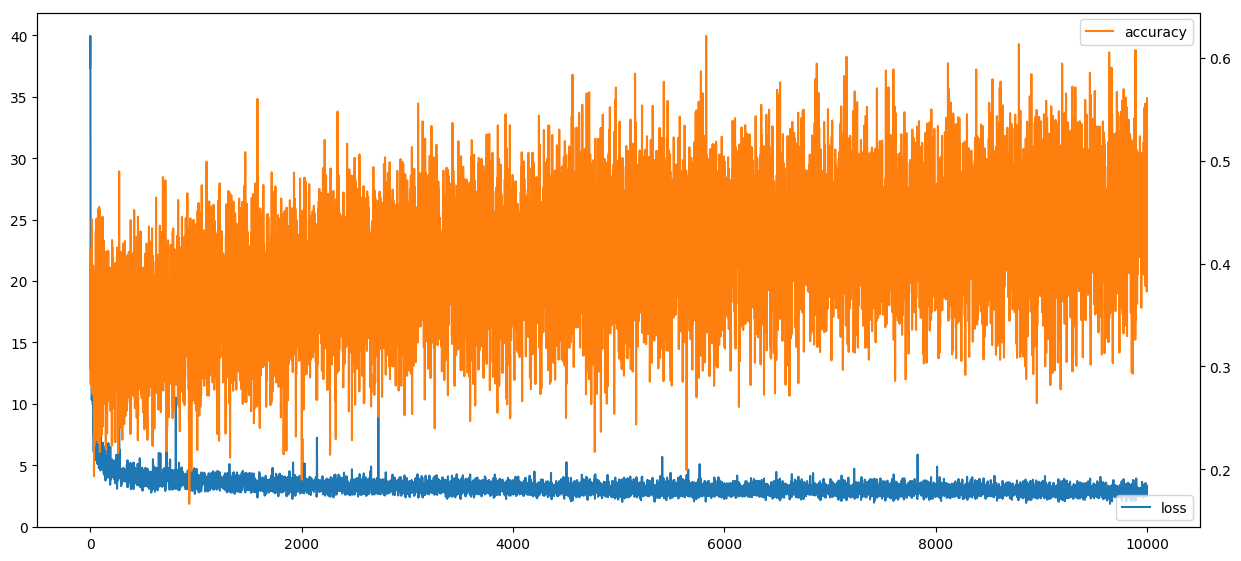

In [23]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()